In [2]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import poisson, nbinom, chisquare, norm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
plt.rc("font", size=14)
plt.style.use("ggplot")
sns.set(style="darkgrid")

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [3]:
seasons = range(2016, 2023 + 1)

In [4]:
pbp = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [5]:
passes = pbp.query('passer_id.notnull()').reset_index()

In [6]:
passes.loc[passes['pass_touchdown'].isnull(), 'pass_touchdown'] = 0

In [7]:
passes.loc[passes['passer'].isnull(), 'passer'] = 'none'

In [8]:
passes.loc[passes['passer_id'].isnull(), 'passer_id'] = 'none'

In [9]:
columns_list = passes.columns.tolist()
print(columns_list)

['index', 'play_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post', 'score_dif

In [10]:
pd.set_option('display.max_columns', None)

In [11]:
selected_columns = ['game_id', 'passer', 'passer_id', 'posteam', 'home_team', 'away_team', 'total', 'spread_line', 'total_line']

In [12]:
joiner = passes[selected_columns]
joiner

,game_id,passer,passer_id,posteam,home_team,away_team,total,spread_line,total_line
0,2016_01_BUF_BAL,J.Flacco,00-0026158,BAL,BAL,BUF,20,3.0,44.5
1,2016_01_BUF_BAL,J.Flacco,00-0026158,BAL,BAL,BUF,20,3.0,44.5
2,2016_01_BUF_BAL,T.Taylor,00-0028118,BUF,BAL,BUF,20,3.0,44.5
3,2016_01_BUF_BAL,T.Taylor,00-0028118,BUF,BAL,BUF,20,3.0,44.5
4,2016_01_BUF_BAL,J.Flacco,00-0026158,BAL,BAL,BUF,20,3.0,44.5
...,...,...,...,...,...,...,...,...,...
178429,2023_22_SF_KC,P.Mahomes,00-0033873,KC,KC,SF,47,-1.5,47.0
178430,2023_22_SF_KC,P.Mahomes,00-0033873,KC,KC,SF,47,-1.5,47.0
178431,2023_22_SF_KC,P.Mahomes,00-0033873,KC,KC,SF,47,-1.5,47.0
178432,2023_22_SF_KC,P.Mahomes,00-0033873,KC,KC,SF,47,-1.5,47.0


In [13]:
user = passes.groupby([
    'season', 'week', 'passer_id', 'game_id', 'passer', 'home_team', 'away_team', 'spread_line'
]).agg({
    'yards_gained': ['sum'],
    'total_line': ['count', 'mean'],
})

In [14]:
user.columns = list(map('_'.join,
                            user.columns
                            ))

In [15]:
user = user.reset_index()
user

,season,week,passer_id,game_id,passer,home_team,away_team,spread_line,yards_gained_sum,total_line_count,total_line_mean
0,2016,1,00-0020531,2016_01_OAK_NO,D.Brees,NO,LV,2.5,419.0,45,50.0
1,2016,1,00-0020679,2016_01_MIN_TEN,S.Hill,TEN,MIN,-2.5,245.0,35,40.0
2,2016,1,00-0021429,2016_01_NE_ARI,C.Palmer,ARI,NE,9.0,252.0,42,44.5
3,2016,1,00-0022803,2016_01_NYG_DAL,E.Manning,DAL,NYG,1.0,203.0,31,47.5
4,2016,1,00-0022924,2016_01_PIT_WAS,B.Roethlisberger,WAS,PIT,-2.5,290.0,38,49.0
...,...,...,...,...,...,...,...,...,...,...,...
5405,2023,21,00-0034796,2023_21_KC_BAL,L.Jackson,BAL,KC,4.5,284.0,47,44.0
5406,2023,21,00-0037834,2023_21_DET_SF,B.Purdy,SF,DET,7.5,310.0,36,52.5
5407,2023,22,00-0033873,2023_22_SF_KC,P.Mahomes,KC,SF,-1.5,361.0,55,47.0
5408,2023,22,00-0036259,2023_22_SF_KC,J.Jennings,KC,SF,-1.5,21.0,1,47.0


In [16]:
joiner.drop(columns = ['total', 'spread_line', 'total_line'], inplace=True)

In [17]:
joiner_use = joiner.drop_duplicates(subset=['game_id', 'passer_id'])
joiner_use

,game_id,passer,passer_id,posteam,home_team,away_team
0,2016_01_BUF_BAL,J.Flacco,00-0026158,BAL,BAL,BUF
2,2016_01_BUF_BAL,T.Taylor,00-0028118,BUF,BAL,BUF
67,2016_01_CAR_DEN,T.Siemian,00-0032156,DEN,DEN,CAR
72,2016_01_CAR_DEN,C.Newton,00-0027939,CAR,DEN,CAR
137,2016_01_CHI_HOU,B.Osweiler,00-0029682,HOU,HOU,CHI
...,...,...,...,...,...,...
178238,2023_21_KC_BAL,L.Jackson,00-0034796,BAL,BAL,KC
178240,2023_21_KC_BAL,P.Mahomes,00-0033873,KC,BAL,KC
178335,2023_22_SF_KC,B.Purdy,00-0037834,SF,KC,SF
178337,2023_22_SF_KC,P.Mahomes,00-0033873,KC,KC,SF


In [18]:
merged_tempo = pd.merge(user, joiner_use, on=["game_id", "passer_id", 'home_team', 'away_team', 'passer'], how='inner')

In [19]:
merged_tempo

,season,week,passer_id,game_id,passer,home_team,away_team,spread_line,yards_gained_sum,total_line_count,total_line_mean,posteam
0,2016,1,00-0020531,2016_01_OAK_NO,D.Brees,NO,LV,2.5,419.0,45,50.0,NO
1,2016,1,00-0020679,2016_01_MIN_TEN,S.Hill,TEN,MIN,-2.5,245.0,35,40.0,MIN
2,2016,1,00-0021429,2016_01_NE_ARI,C.Palmer,ARI,NE,9.0,252.0,42,44.5,ARI
3,2016,1,00-0022803,2016_01_NYG_DAL,E.Manning,DAL,NYG,1.0,203.0,31,47.5,NYG
4,2016,1,00-0022924,2016_01_PIT_WAS,B.Roethlisberger,WAS,PIT,-2.5,290.0,38,49.0,PIT
...,...,...,...,...,...,...,...,...,...,...,...,...
5405,2023,21,00-0034796,2023_21_KC_BAL,L.Jackson,BAL,KC,4.5,284.0,47,44.0,BAL
5406,2023,21,00-0037834,2023_21_DET_SF,B.Purdy,SF,DET,7.5,310.0,36,52.5,SF
5407,2023,22,00-0033873,2023_22_SF_KC,P.Mahomes,KC,SF,-1.5,361.0,55,47.0,KC
5408,2023,22,00-0036259,2023_22_SF_KC,J.Jennings,KC,SF,-1.5,21.0,1,47.0,SF


In [20]:
sortski = merged_tempo.sort_values(by='game_id')
sortski.rename(columns = {'posteam': 'qbteam',
                          "total_line_count": "n_passes",
                          'spread_line': 'away_spread'}, inplace=True)

In [21]:
sortski = sortski.query("n_passes >= 10")
sortski['home_spread'] = sortski['away_spread'] * -1

In [22]:
def calculate_implied_total(row):
    if row['qbteam'] == row['home_team']:
        # If the QB's team is the home team, use the home spread
        team_implied_total = (row['total_line_mean'] / 2) + (row['away_spread'] / 2)
    else:
        # If the QB's team is the away team, use the away spread (inverting since away_spread is opposite in sign)
        team_implied_total = (row['total_line_mean'] / 2) + (row['home_spread'] / 2)
    return team_implied_total


In [23]:
sortski['implied_total'] = sortski.apply(calculate_implied_total, axis=1)

In [24]:
sortski.rename(columns={
    "total_line_mean": "total_line",
    "yards_gained_sum": "pass_yards"
},
inplace = True)

In [25]:
# Group by season and week, then calculate the highest passing yards for each group
highest_passing_yards = sortski.groupby(['season', 'week'])['pass_yards'].transform('max')

# Create a new column for the highest passing yards of the week
sortski['highest_passing_yards_of_week'] = highest_passing_yards

# Create a 1,0 flag for "is highest passing yards"
sortski['is_highest_passing_yards'] = (sortski['pass_yards'] == sortski['highest_passing_yards_of_week']).astype(int)

<Axes: xlabel='pass_yards', ylabel='Count'>

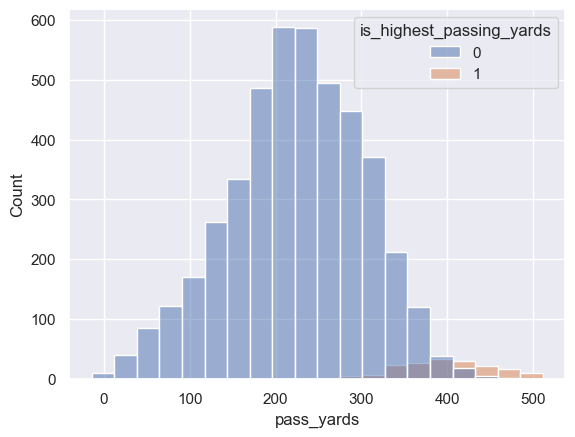

In [26]:
sns.histplot(data=sortski, x="pass_yards", hue='is_highest_passing_yards', bins=20)

<Axes: xlabel='implied_total', ylabel='pass_yards'>

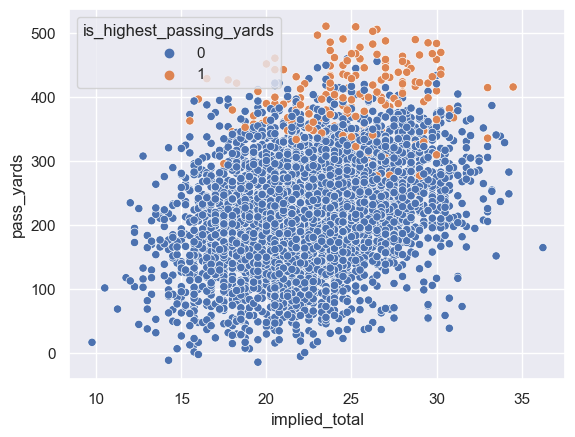

In [27]:
sns.scatterplot(data=sortski, x="implied_total", y="pass_yards", hue="is_highest_passing_yards")

In [41]:
sortski['implied_total'].value_counts(ascending=True)

10.50      1
36.25      1
11.75      1
34.50      1
11.25      1
34.00      1
9.75       1
12.50      2
32.25      2
34.25      2
33.50      2
12.00      2
33.75      2
33.25      3
32.50      3
32.75      4
12.75      4
32.00      5
13.00      5
13.75      5
12.25      5
13.25      7
33.00      7
13.50      7
31.50      7
14.00      7
31.00      9
31.25      9
31.75     10
14.25     10
14.75     11
14.50     15
15.25     15
30.75     19
30.50     20
15.00     20
29.50     20
15.50     21
30.00     23
30.25     24
16.25     25
29.25     27
16.00     30
29.75     30
28.75     35
17.75     37
15.75     38
29.00     39
28.50     40
28.25     40
17.25     42
17.00     43
16.75     44
16.50     44
28.00     53
27.50     54
27.75     55
27.25     58
17.50     58
26.50     60
18.25     65
18.50     65
18.00     70
19.75     71
27.00     71
26.75     73
26.00     81
19.00     82
26.25     83
19.25     84
25.50     86
20.00     87
20.75     90
25.75     90
25.00     92
19.50     92
24.25     93

In [29]:
#notes
#take average of pass yards from games with same implied total +- 4(?) points
#find standard dev for these as well
#use appropriate distribution 

In [30]:
sortski[sortski['game_id'] == '2016_16_NYJ_NE']

,season,week,passer_id,game_id,passer,home_team,away_team,away_spread,pass_yards,n_passes,total_line,qbteam,home_spread,implied_total,highest_passing_yards_of_week,is_highest_passing_yards
533,2016,16,00-0023682,2016_16_NYJ_NE,R.Fitzpatrick,NE,NYJ,17.0,139.0,23,45.0,NYJ,-17.0,14.0,358.0,0
523,2016,16,00-0019596,2016_16_NYJ_NE,T.Brady,NE,NYJ,17.0,205.0,31,45.0,NE,-17.0,31.0,358.0,0


In [39]:
sortski['pass_yards'].std()

84.89613342285156

In [31]:
# Calculate adjusted mean and std dev for passing yards within ±4 points of implied total for each QB
def calc_adjusted_stats(row):
    close_games = sortski[np.abs(sortski['implied_total'] - row['implied_total']) <= 4]
    mean_pass_yards = close_games['pass_yards'].mean()
    std_pass_yards = sortski['pass_yards'].std()  # League Standard Deviation
    return pd.Series([mean_pass_yards, std_pass_yards])

sortski[['adjusted_mean', 'adjusted_std']] = sortski.apply(calc_adjusted_stats, axis=1)

In [36]:
def simulate_highest_passing_yards(df, number_of_simulations=10000):
    # Assuming 'league_passing_std_dev' is the league-wide standard deviation of passing yards
    league_passing_std_dev =  sortski['pass_yards'].std() # Using the mean of adjusted standard deviations as a placeholder

    df['count_simulated_is_highest_passing'] = 0

    for sim in range(number_of_simulations):
        # Simulate passing yards for each QB
        df['simulated_passing_yards'] = np.random.normal(df['adjusted_mean'], league_passing_std_dev).round(0)
        
        # Determine the highest simulated passing yards of each week and merge it back onto the dataframe
        max_passing_df = df.groupby(['week', 'season'])['simulated_passing_yards'].agg('max').reset_index()
        max_passing_df.columns = ['week', 'season', 'simulated_highest_passing_of_week']
        df = df.merge(max_passing_df, on=['week', 'season'], how='left')
        
        # Identify if each QB had the highest simulated passing yards of the week
        df['simulated_is_highest_passing'] = np.where(df['simulated_highest_passing_of_week'] == df['simulated_passing_yards'], 1, 0)
        
        # Count ties and distribute the count evenly among them
        df['total_qbs_with_highest_passing'] = df.groupby(['week', 'season'])['simulated_is_highest_passing'].transform('sum')
        df['count_simulated_is_highest_passing'] += np.where(df['simulated_is_highest_passing'] == 1, 1 / df['total_qbs_with_highest_passing'], 0)
        
        # Drop columns to avoid duplicate name clashes in the next iteration
        df.drop(columns=['simulated_highest_passing_of_week', 'simulated_is_highest_passing', 'total_qbs_with_highest_passing'], inplace=True)

    # Calculate the probability of each QB having the highest simulated passing yards of the week
    df['simulated_highest_passing_probability'] = df['count_simulated_is_highest_passing'] / number_of_simulations

    return df

In [37]:
# Simulate which QB is most likely to have the highest passing yards
simulated_df = simulate_highest_passing_yards(sortski)

#Only use +- for adjusted means when there are less than X games with that implied total, use league stdev for all, FIGURE OUT WHY ADJUSTED STDEV ISNT GOING ANYWHERE IN FINAL DF


In [38]:
# Display a summary of the simulation results
simulated_df.sort_values(by='simulated_highest_passing_probability', ascending=False)

,season,week,passer_id,game_id,passer,home_team,away_team,away_spread,pass_yards,n_passes,total_line,qbteam,home_spread,implied_total,highest_passing_yards_of_week,is_highest_passing_yards,adjusted_mean,adjusted_std,count_simulated_is_highest_passing,simulated_passing_yards,simulated_highest_passing_probability
1110,2017,21,00-0019596,2017_21_PHI_NE,T.Brady,NE,PHI,4.5,506.0,51,48.5,NE,-4.5,26.50,506.0,1,252.854965,84.896133,5931.5,172.0,0.59315
3376,2021,22,00-0026498,2021_22_LA_CIN,M.Stafford,CIN,LA,-4.5,277.0,46,48.5,LA,4.5,26.50,277.0,1,252.854965,84.896133,5856.5,206.0,0.58565
2780,2020,21,00-0033873,2020_21_KC_TB,P.Mahomes,TB,KC,-3.0,277.0,61,55.0,KC,3.0,29.00,277.0,1,265.890900,84.896133,5489.0,330.0,0.54890
552,2016,21,00-0019596,2016_21_NE_ATL,T.Brady,ATL,NE,-3.0,459.0,73,57.0,NE,3.0,30.00,459.0,1,269.840027,84.896133,5397.5,233.0,0.53975
1661,2018,21,00-0019596,2018_21_NE_LA,T.Brady,LA,NE,-2.0,253.0,40,55.5,NE,2.0,28.75,253.0,1,264.559509,84.896133,5388.5,311.0,0.53885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,2018,3,00-0034857,2018_03_BUF_MIN,J.Allen,MIN,BUF,16.5,194.0,31,41.0,BUF,-16.5,12.25,420.0,0,165.193130,84.896133,37.0,-19.0,0.00370
444,2016,15,00-0033106,2016_15_LA_SEA,J.Goff,SEA,LA,15.0,104.0,34,39.5,LA,-15.0,12.25,358.0,0,165.193130,84.896133,34.0,348.0,0.00340
1749,2019,3,00-0034343,2019_03_MIA_DAL,J.Rosen,DAL,MIA,22.0,195.0,47,46.5,MIA,-22.0,12.25,450.0,0,165.193130,84.896133,33.0,163.0,0.00330
1755,2019,3,00-0034412,2019_03_NYJ_NE,L.Falk,NE,NYJ,20.5,69.0,30,43.0,NYJ,-20.5,11.25,450.0,0,156.546219,84.896133,20.0,167.0,0.00200


In [56]:
def printRocCurve(y_test, predicted_probabilities, auc):
    fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)
    plt.figure()
    plt.plot(fpr, tpr, label=' (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

AUC: 0.7184583765368093
Logloss: 0.14598886193631447
Brier: 0.03422148623510168


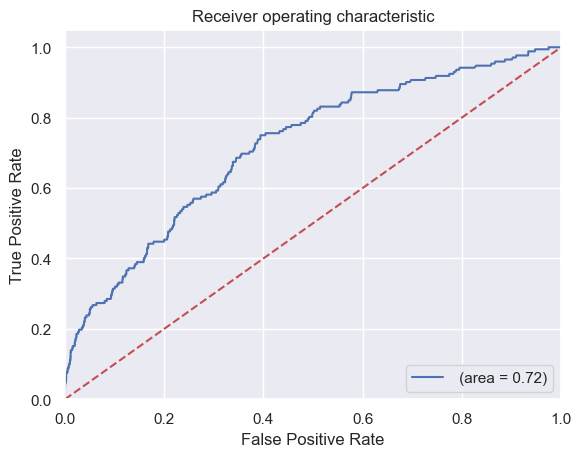

In [ ]:
auc = roc_auc_score(simulated_df['is_highest_passing_yards'], simulated_df['simulated_highest_passing_probability'])
logloss = log_loss(simulated_df['is_highest_passing_yards'], simulated_df['simulated_highest_passing_probability'])
brier = brier_score_loss(simulated_df['is_highest_passing_yards'], simulated_df['simulated_highest_passing_probability'])

print("AUC: " + str(auc))
print("Logloss: " + str(logloss))
print("Brier: " + str(brier))

printRocCurve(simulated_df['is_highest_passing_yards'], simulated_df['simulated_highest_passing_probability'], auc)

In [58]:
divisional_projections = simulated_df[(simulated_df['week'] == 12) & (simulated_df['season'] == 2023)]

divisional_projections = divisional_projections[['passer','simulated_passing_yards','simulated_highest_passing_probability']]

divisional_projections = divisional_projections.rename(columns={"passer": "QB", "simulated_passing_yards": "Simulated Passing Yards", 
                                                                "simulated_highest_passing_probability": "Probability"})

divisional_projections['Price'] = 1000*round(round((100-100*divisional_projections['Probability'])/divisional_projections['Probability'],0)/1000,2)

divisional_projections['Price'] = "+" + divisional_projections['Price'].map('{:.0f}'.format).astype(str)

total_probability = divisional_projections['Probability'].sum()

divisional_projections = divisional_projections.sort_values(by=['Probability'], ascending=False)

divisional_projections['Probability'] = divisional_projections['Probability'].map('{:,.2%}'.format)

print(divisional_projections)

print('Total Probability: {:,.2%}'.format(total_probability))

                       QB  Simulated Passing Yards Probability   Price
4342           D.Prescott                    214.0       8.58%   +1070
4321               J.Goff                    281.0       6.62%   +1410
4311            L.Jackson                    218.0       5.04%   +1880
4325            P.Mahomes                    168.0       5.00%   +1900
4313              J.Hurts                    172.0       4.64%   +2060
4329         T.Tagovailoa                    134.0       4.50%   +2120
4339              B.Purdy                    165.0       4.47%   +2130
4323           T.Lawrence                    407.0       4.16%   +2300
4312              J.Allen                    360.0       3.83%   +2510
4328           M.Stafford                    233.0       3.72%   +2590
4340         G.Minshew II                    257.0       3.65%   +2640
4324             C.Stroud                    145.0       3.59%   +2690
4310            J.Herbert                    232.0       3.44%   +2810
4317  

In [59]:
simulated_df[(simulated_df['week'] == 12) & (simulated_df['season'] == 2023)].sort_values(by = "pass_yards", ascending = False)

,season,week,passer_id,game_id,passer,home_team,away_team,away_spread,pass_yards,n_passes,total_line,qbteam,home_spread,implied_total,highest_passing_yards_of_week,is_highest_passing_yards,adjusted_mean,adjusted_std,count_simulated_is_highest_passing,simulated_passing_yards,simulated_highest_passing_probability
4312,2023,12,00-0034857,2023_12_BUF_PHI,J.Allen,PHI,BUF,2.5,397.0,59,49.0,BUF,-2.5,23.25,397.0,1,235.339569,84.896133,383.0,360.0,0.03830
4323,2023,12,00-0036971,2023_12_JAX_HOU,T.Lawrence,HOU,JAX,-1.0,366.0,43,48.0,JAX,1.0,24.50,397.0,0,242.291672,84.896133,416.0,407.0,0.04160
4342,2023,12,00-0033077,2023_12_WAS_DAL,D.Prescott,DAL,WAS,13.0,343.0,35,48.0,DAL,-13.0,30.50,397.0,0,274.840759,84.896133,857.5,214.0,0.08575
4321,2023,12,00-0033106,2023_12_GB_DET,J.Goff,DET,GB,8.5,335.0,55,47.0,DET,-8.5,27.75,397.0,0,262.101746,84.896133,662.5,281.0,0.06625
4324,2023,12,00-0039163,2023_12_JAX_HOU,C.Stroud,HOU,JAX,-1.0,308.0,47,48.0,HOU,1.0,23.50,397.0,0,236.627243,84.896133,359.0,145.0,0.03590
4335,2023,12,00-0031280,2023_12_NO_ATL,D.Carr,ATL,NO,-2.0,304.0,43,42.0,NO,2.0,22.00,397.0,0,227.099335,84.896133,272.5,191.0,0.02725
4325,2023,12,00-0033873,2023_12_KC_LV,P.Mahomes,LV,KC,-9.0,302.0,38,42.5,KC,9.0,25.75,397.0,0,249.642456,84.896133,500.0,168.0,0.05000
4343,2023,12,00-0037077,2023_12_WAS_DAL,S.Howell,DAL,WAS,13.0,280.0,52,48.0,WAS,-13.0,17.50,397.0,0,201.901077,84.896133,158.5,324.0,0.01585
4337,2023,12,00-0038102,2023_12_PIT_CIN,K.Pickett,CIN,PIT,-2.0,276.0,40,36.0,PIT,2.0,19.00,397.0,0,210.411407,84.896133,194.0,357.0,0.01940
4322,2023,12,00-0036264,2023_12_GB_DET,J.Love,DET,GB,8.5,270.0,34,47.0,GB,-8.5,19.25,397.0,0,210.991592,84.896133,193.5,224.0,0.01935
